# DeepFeature: DeepInsight CAM-based Feature Selection Example

This example shows a case of using class activation maps (CAMs) and a trained model to identify important feature in class prediction as proposed in *[DeepFeature: feature selection in nonimage data using convolutional neural network](https://doi.org/10.1093/bib/bbab297)*. The first three sections are the same steps taken in the [pyTorch SqueezeNet example](./pytorch_squeezenet.ipynb). Please see that example for a fuller explaination of these steps. 

### Jump to section
* [TCGA RNASeq2GeneNorm data](#load_data)
* [DeepInsight: Image Transformation](#deepinsight)
* [SqueezeNet Image Classification](#squeezenet)
* **[DeepFeature: CAM-based Feature Selection](#deepfeature)**

In [1]:
from pyDeepInsight import ImageTransformer, LogScaler, CAMFeatureSelector

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

<a id='load_data'></a>
## TCGA RNASeq2GeneNorm data

Here we load the TCGA primary tumor RNASeq data for 8 cancer types as described in the data [README.md](./data/README.md#curatedTCGAData_RNASeq2GeneNorm-20160128)

In [2]:
expr_file = r"./data/curatedTCGAData_RNASeq2GeneNorm-20160128.txt.gz"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values

random_state=1515
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y)

In [3]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

le_mapping = dict(zip(le.transform(le.classes_), le.classes_))
num_classes = np.unique(y_train_enc).size

<a id='deepinsight'></a>
## DeepInsight: Image Transformation
Convert data to image format using DeepInsight

In [4]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    square_distances=True,
    n_jobs=-1
)
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

In [5]:
X_train_img = it.fit_transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

<a id='squeezenet'></a>
## SqueezeNet Image Classification
Train SqueezeNet CNN

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
net = torch.hub.load(
    'pytorch/vision:v0.10.0', 'squeezenet1_1', 
    pretrained=True, verbose=False)
net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), 
                              stride=(1,1))
net = net.to(device)

In [8]:
batch_size=200
preprocess = transforms.Compose([transforms.ToTensor()])

X_train_tensor = torch.stack([preprocess(img) for img in X_train_img]).float().to(device)
y_train_tensor = torch.from_numpy(le.fit_transform(y_train)).to(device)
trainset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

X_test_tensor = torch.stack([preprocess(img) for img in X_test_img]).float().to(device)
y_test_tensor = torch.from_numpy(le.transform(y_test)).to(device)
testset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    net.parameters(), 
    lr=1e-04,
    momentum=0.8,
    weight_decay=1e-05
)

In [10]:
net.train()
for epoch in range(200):
    for i, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [11]:
test_predicted = np.empty(0)
test_true = np.empty(0)

net.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader):
        pred = torch.max(net(inputs),1)[1].cpu().detach().numpy()
        test_predicted = np.append(test_predicted, pred)
        test_true = np.append(test_true, labels.cpu().detach().numpy())
print(f"The test accuracy was {accuracy_score(test_predicted, test_true):.3f}")

The test accuracy was 0.970


<a id='deepfeature'></a>
## DeepFeature: CAM-based Feature Selection

The feature selection method uses the class activation maps of all samples in a class to identify important features for differenting classes. The DeepInsight CAM-base feature selection is done in 3 steps.

Step 1: create the `CAMFeatureSelector` object. This class must be provided with the previously constructed DeepInsight `ImageTransformer` object and the CNN model trained using the output of that object. In addition, there are two optional parameters: 

* target_layer: the layer of the CNN model to use to compute the CAM. This can be the name of the layer or the layer itself. If none is given, CAMFeatureSelector will choose an appropriate layer using methods from the package [torchcam](https://github.com/frgfm/torch-cam).
* cam_method: name of the CAM method from the package [grad-cam](https://github.com/jacobgil/pytorch-grad-cam). The default is "GradCAM".

In [17]:
camfs = CAMFeatureSelector(model=net, it=it, )

In [18]:
act = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method="mean")
feat_idx = camfs.select_class_features(it=it, cams = act)

In [19]:
for cat, idx in feat_idx.items():
    print(f"{le_mapping[cat]} has {idx.shape[0]} features selected")

BRCA has 1918 features selected
HNSC has 1485 features selected
KIRC has 2256 features selected
LGG has 648 features selected
LUAD has 2215 features selected
LUSC has 1889 features selected
THCA has 1644 features selected
UCEC has 2564 features selected


In [21]:
from pytorch_grad_cam.utils.image import show_cam_on_image
from matplotlib import pyplot as plt

def cam_image(X, y, cam, fs):
    fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(8, 8),
                            constrained_layout=True)
    axs[-1,-1].axis('off')

    for cat in np.unique(y):
        row = cat // 3
        col = cat % 3

        cat_idx = np.where(y == cat)[0]
        X_cat = X[cat_idx,:,:,:].detach().mean(dim=0).cpu().numpy()
        act_cat = act[cat]

        visualization = show_cam_on_image(
            np.transpose(X_cat, (1,2,0)),
            act_cat,
            use_rgb=True
        )
        _ = axs[row, col].imshow(visualization)
        axs[row, col].text(0,0,le_mapping[cat],c="white",ha="left",va="top",weight="bold",size="x-large")
        axs[row, col].text(227,227,f"{feat_idx[cat].shape[0]} genes",c="white",ha="right",va="bottom",weight="bold",size="large")
        axs[row, col].axis('off')
    plt.show()

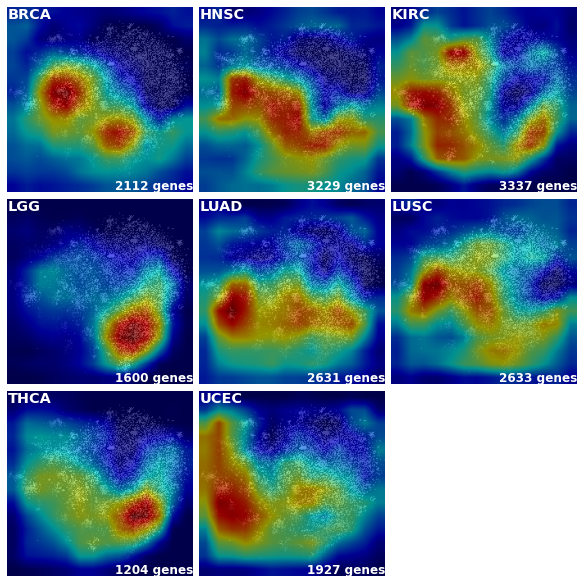

In [22]:
cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), act, feat_idx)

In [ ]:
act = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method="min")
feat_idx = camfs.select_class_features(it=it, cams = act)
cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), act, feat_idx)

In [ ]:
act = camfs.calculate_class_activations(X_train_tensor, y_train_tensor, batch_size=100, flatten_method="max")
feat_idx = camfs.select_class_features(it=it, cams = act)
cam_image(X_train_tensor, y_train_tensor.detach().cpu().numpy(), act, feat_idx)